In [1]:
library(tidyverse)
library(ncdf4)
library(viridis)
library(fields)
library(rstan)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘purrr’ was built under R version 3.6.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps


A

In [2]:
nc <- nc_open("data/Zinser_SizeDist_calibrated-26-6.nc")
PAR   <- ncvar_get(nc,'PAR')
w_obs <- ncvar_get(nc,'w_obs')
m     <- ncvar_get(nc,'m')
delta_v_inv <- ncvar_get(nc,'delta_v_inv')
v_min       <- ncvar_get(nc,'v_min')
time  <- ncvar_get(nc,'time')
time <- as.POSIXct(time*60, origin="2009-05-01")
delta_v <- 1/delta_v_inv
v       <- v_min*2^(0:25*delta_v) 

In [3]:
df <- read.csv("data/Zinser_Figure2A.csv")
abundance <- rowMeans(df[,c(3,2)]) # mean of culture A and B

clean <- smooth.spline(time, abundance, df=15) # smooth abundance data using spline


df2 <- read.csv("data/Zinser_Figure3.csv")

- ### Equation division rate (assuming exponential growth)
$$
DR = ln(\frac{N_1/N_0}t)

In [4]:
dr <- diff(log(clean$y))/diff(clean$x/3600) # calculate hourly division rate

[1] "Division rate =  0.631 / day"


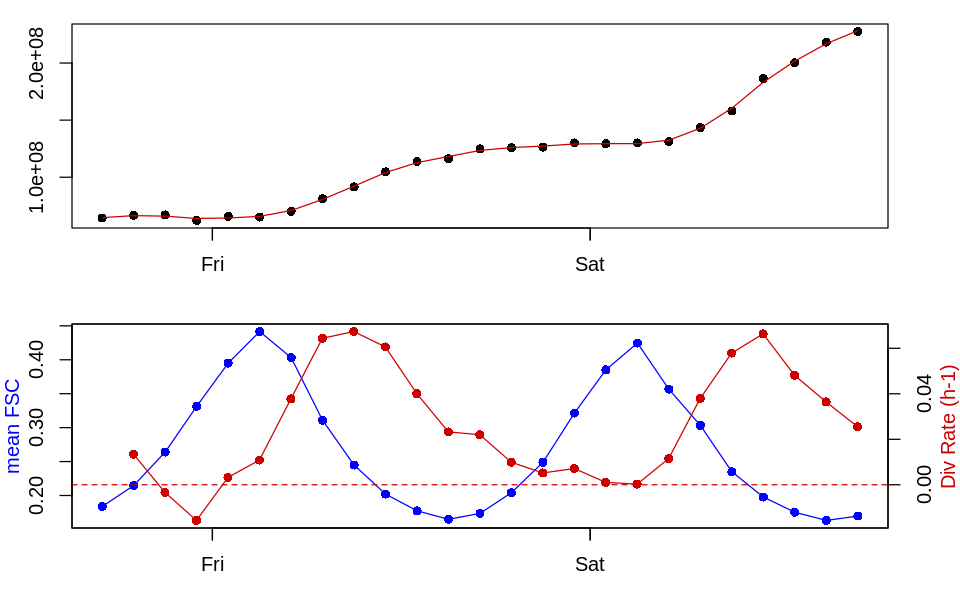

In [5]:
options(repr.plot.width = 8, repr.plot.height = 5)

par(mfrow=c(2,1), mar=c(3,3,1,3))
plot(time, abundance, pch=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(1,10^9,10^9,1),2), border=NA, col='lightgrey')
points(time, abundance, pch=16)
lines(clean,col="red3" )
plot(time, df[,c(4)], pch=NA, xlab=NA, ylab=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(-1,1,1,-1),2), border=NA, col='lightgrey')
lines(time, df[,c(4)], col='blue1', type="o", pch=16)
par(new=T)
plot(x=time[-1]-50,y=dr, type='o', pch=16, xaxt='n', yaxt='n', col="red3", xlab=NA, ylab=NA, xlim=range(time))
axis(4) 
mtext("Div Rate (h-1)", 4,2, col="red3")
mtext("mean FSC", 2,2, col="blue1")
abline(h=0, lty=2,col="red3")
print(paste("Division rate = ",round(24*mean(dr),3), "/ day"))


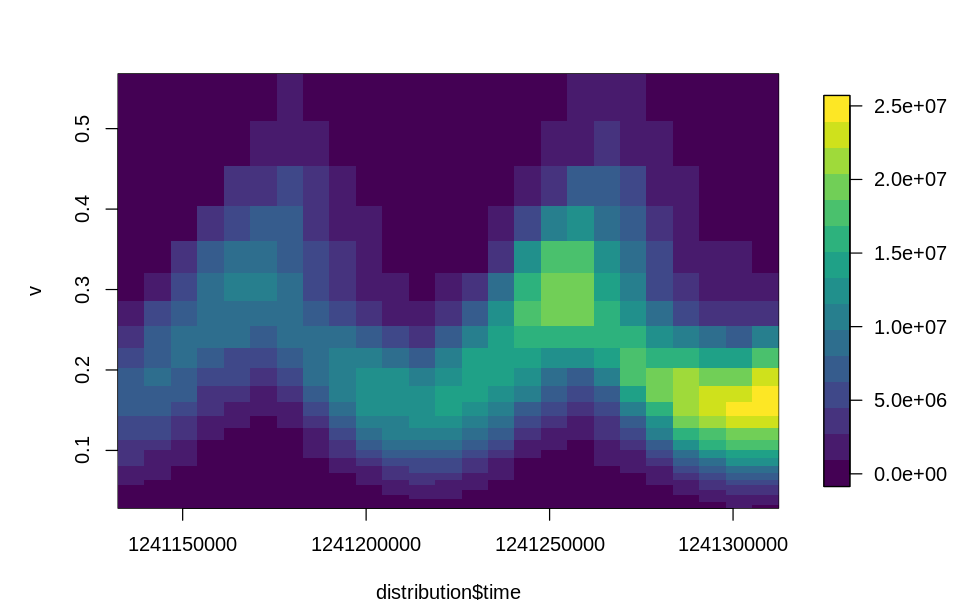

In [6]:
w_obs2 <- round(w_obs * abundance)
dist <- as.data.frame(w_obs2)
dist$time <- time

dist <- dist[,c(27,1:26)] # reorganize dataframe to be compatible with ssPopModel


resol.i <- 120 # in minutes
# Extrapolate dat based on "resol"
DF <- NULL
for(i in 1:dim(dist)[2]){
     df <- approx(dist$time, dist[,i], xout=seq(min(time), max(time), by=60*resol.i))
     DF <- cbind(DF, df$y)
    }
colnames(DF) <- c("time", v)

### select 1 day Size distribution
id <- c(1:25)   
distribution <- as.data.frame(DF[,])

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=as.matrix(distribution[,-c(1)]), col=viridis(15))

In [7]:
## PAR data
# resolution
resol <- 10 # in minutes

# select PAR data covering the range of the size distribution
par <- data.frame(time=time, par=PAR)
par <- subset(par, time  >= min(distribution$time) & time  < max(distribution$time))

# Change temporal resolution 
E <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60*resol))

# smooth spline
ep <- smooth.spline(E, all.knots=TRUE)
Edata <- ep$y
Edata[Edata < 0] <- 0

# #plot
# options(repr.plot.width = 8, repr.plot.height = 8)
# plot(par$time,par$par, type='p', xlab=NA, ylab="Light")
# points(ep$x,Edata, col=4, lwd=3)

In [8]:
models <- c('m1','m2','m3','m4','m5','m6')
#    'm1': '../stancode/matrixmodel_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
#    'm2': '../stancode/matrixmodel_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
#    'm3': '../stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
#    'm4': '../stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',
#    'm5': '../stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
#    'm6': '../stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',

SF=ZN <- list()
for(i in 1:length(models)){
    #SF[[i]] <- read.csv(paste('fit',models[i],'seaflow.csv',sep='_'))
    ZN[[i]] <- read.csv(paste('parameter_plots/fit',models[i],'zinser.csv',sep='_'))
}

In [10]:
##################
### parameters ###
##################
pars <- c('gamma_max','E_star','respiration','divrate')

PARS_sf=PARS_zn   <- array(NA,dim=c(dim(ZN[[1]])[1],length(pars),length(models)))
#colnames(pars_sf)=colnames(pars_zn) <- pars
for(j in 1:length(models)){
    pars_sf=pars_zn                     <- matrix(NA,dim(ZN[[1]])[1],length(pars))
    colnames(pars_sf)=colnames(pars_zn) <- pars
    for(i in 1:length(pars)){
        #pars_sf[,i] <- SF[[j]][,grep(pars[i],colnames(SF[[j]]))]
        pars_zn[,i] <- ZN[[j]][,grep(pars[i],colnames(ZN[[j]]))]
    }
    #PARS_sf[,,j] <- pars_sf
    PARS_zn[,,j] <- pars_zn
}


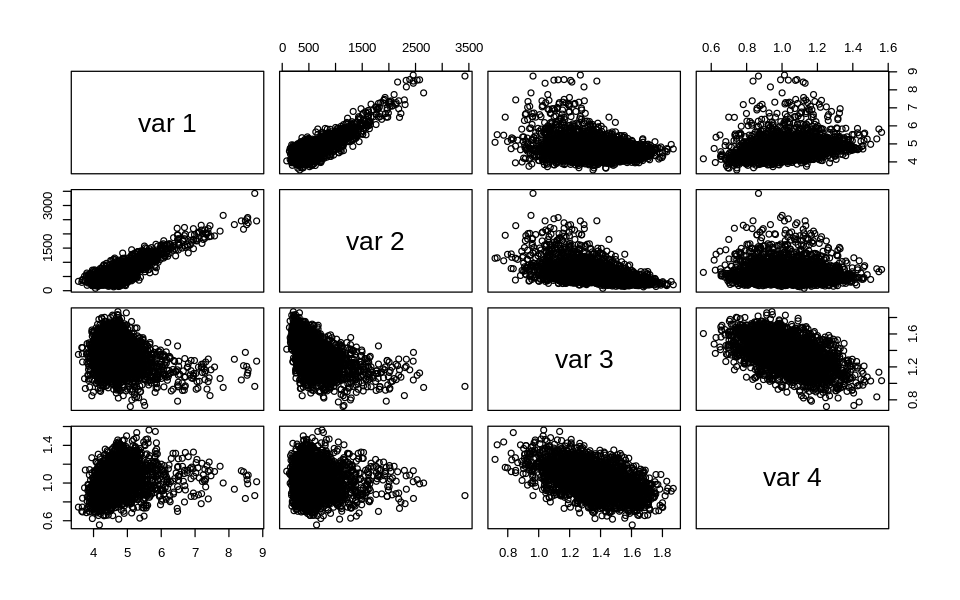

In [11]:
pairs(PARS_zn[,,1])

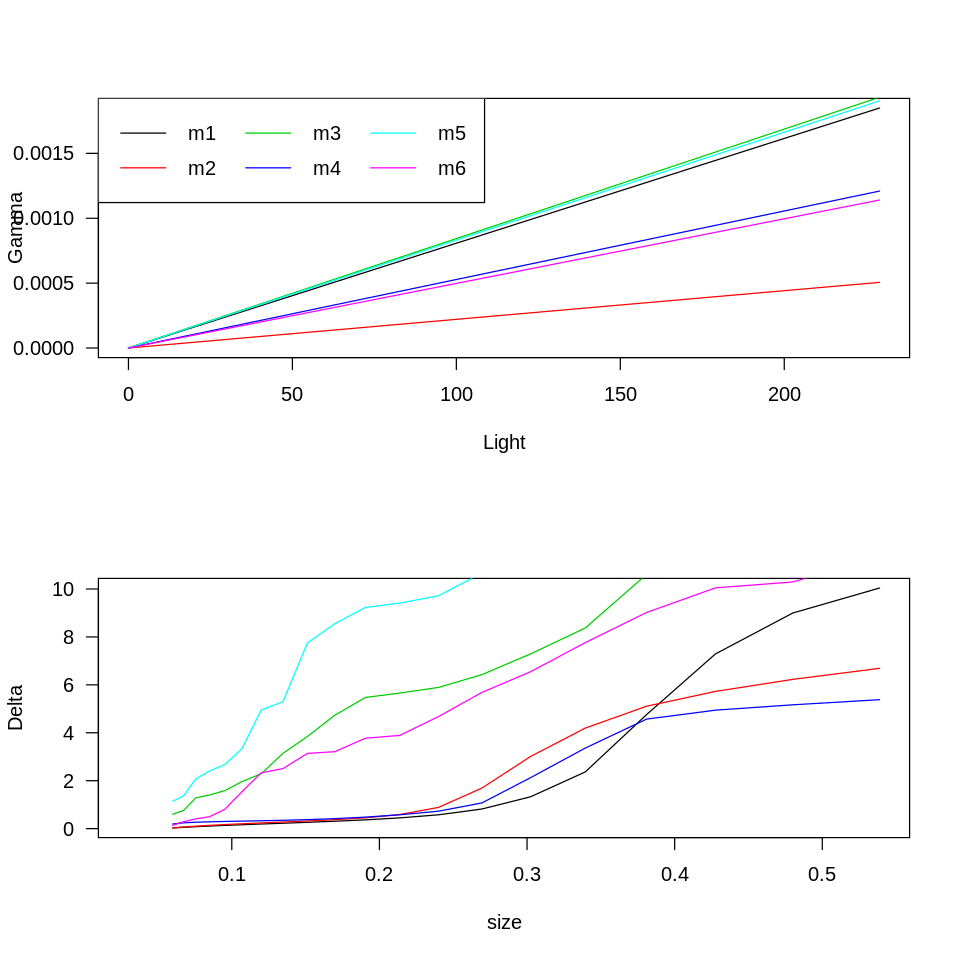

In [12]:
source("scripts/functions_model.R")
id1 <- which(colnames(ZN[[1]]) == "delta_max.1.")
id2 <- which(colnames(ZN[[1]]) == "delta_max.20.")

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,1))
plot(Edata, gamma_t(Edata, mean(ZN[[1]]$gamma_max), mean(ZN[[1]]$E_star)), type='l', xlab="Light", ylab=paste("Gamma"), las=1)
for(i in 2:6) lines(Edata, gamma_t(Edata, mean(ZN[[i]]$gamma_max), mean(ZN[[i]]$E_star)), col=i)
legend("topleft",models, col=1:6, lwd=1, ncol=3)

plot(v[7:26], colMeans(ZN[[1]][id1:id2]), type='l', xlab="size", ylab=paste("Delta"), las=1, xlim=range(v))    
for(i in 2:6){
    id1 <- which(colnames(ZN[[i]]) == "delta_max.1.")
    id2 <- which(colnames(ZN[[i]]) == "delta_max.20.")
    lines(v[7:26], colMeans(ZN[[i]][id1:id2]), col=i)
}

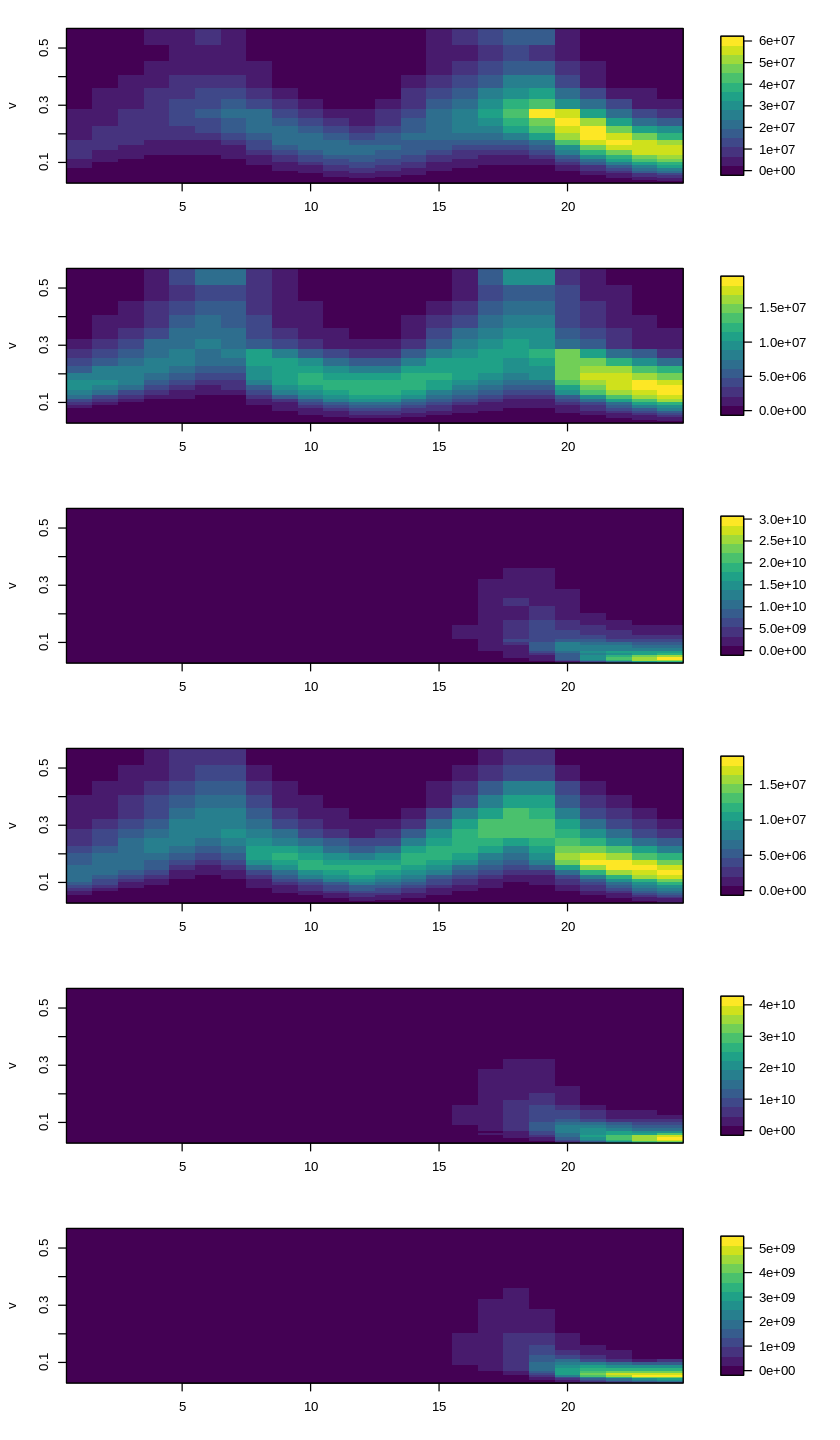

In [26]:
options(repr.plot.width=7, repr.plot.height=12)
par(mfrow=c(6,1),mar=c(2,4,1,2))

Nproj <- list()
for(i in 1:length(models)){
    id1 <- which(colnames(ZN[[i]]) == "mod_obspos.1.1.")
    id2 <- which(colnames(ZN[[i]]) == "mod_obspos.26.24.")
    Nproj[[i]] <- matrix(data=colMeans(ZN[[i]][id1:id2]), nrow=26, ncol=24) * clean$y[1]
    image.plot(x=1:24,y=v,t(Nproj[[i]]),col=viridis(15),xlab=''); box()
}

[1] "daily growth rate= 2.18"
[1] "daily growth rate= 1.05"
[1] "daily growth rate= 8.49"
[1] "daily growth rate= 0.96"
[1] "daily growth rate= 8.82"
[1] "daily growth rate= 6.59"


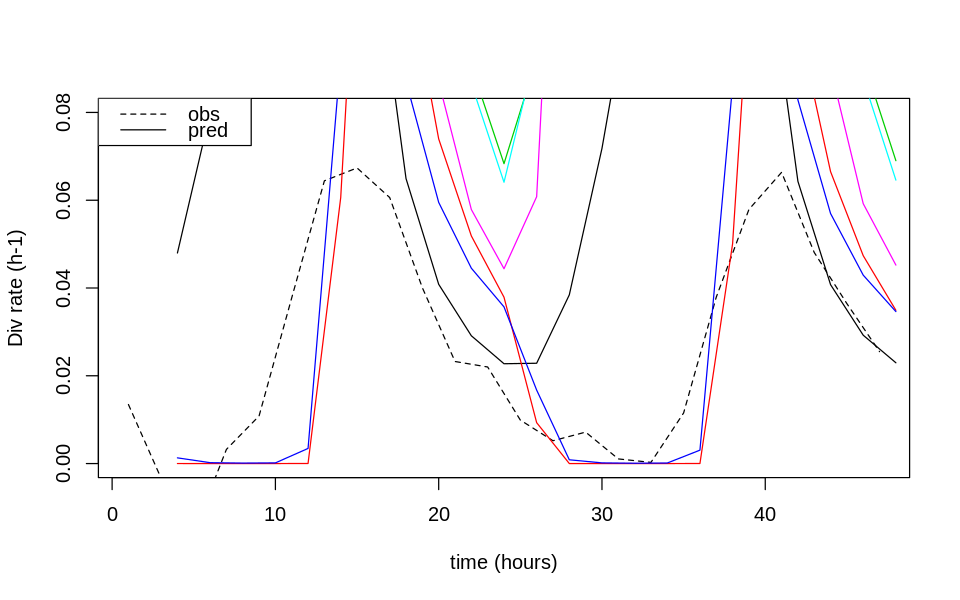

In [27]:
###############################
## Division rate calculation ##
###############################

mu_N <- list()
for(i in 1:length(models)){
    mu_N[[i]] <- diff(log(colSums(Nproj[[i]], na.rm=T)))
    print(paste("daily growth rate=",round(24*mean(mu_N[[i]], na.rm=T),2)))
}

#plot
options(repr.plot.width = 8, repr.plot.height = 5)
plot(seq(1,48,2), y=dr, lty=2,type='l', ylim=c(0,0.08), xlab='time (hours)', ylab="Div rate (h-1)")
for(i in 1:length(models)) lines(seq(4,48,2), y=mu_N[[i]], col=i)
legend("topleft",c("obs","pred"), lty=c(2,1))

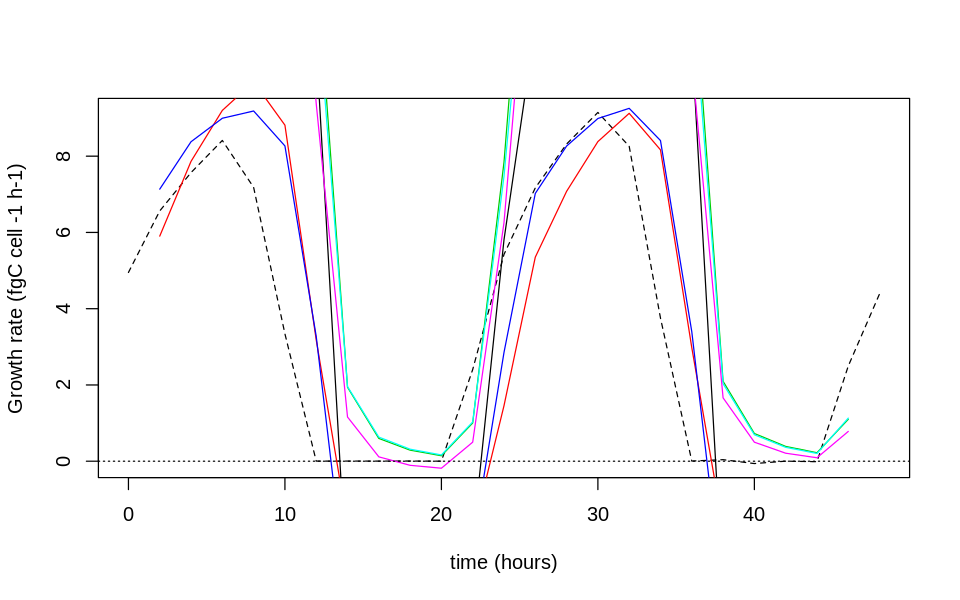

In [28]:
#############################
## Growth rate calculation ##
#############################
#c <- v  * 256 # based on Binder 
c <- 261 * (1*v)^0.861 # Menden-Deuer # NOTE we can multiply Volume by 1.5 to make our estimates of light-scatter based volume fit Carbon measurements
light <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60 * 60))$y

# Obs Net growth rate
biom1 <-  diag(c) %*%  t(as.matrix(distribution[,-c(1)]))
gr1 <- diff(colSums(biom1)) / rowSums(distribution[,-c(1)])[-1]

# Proj Net growth rate
gr <- list()
for(i in 1:length(models)){
    biom <-  diag(c) %*%  Nproj[[i]]
    gr[[i]] <- diff(colSums(biom)) / colSums(Nproj[[i]])[-1]
}

options(repr.plot.width = 8, repr.plot.height = 5)
plot(seq(0,48,2), df2[,3], type="l", lty=2, xlab='time (hours)', ylab="Growth rate (fgC cell -1 h-1)")
for(i in 1:length(models)) lines(seq(2,46,2), gr[[i]], col=i); abline(h=0, lty=3)

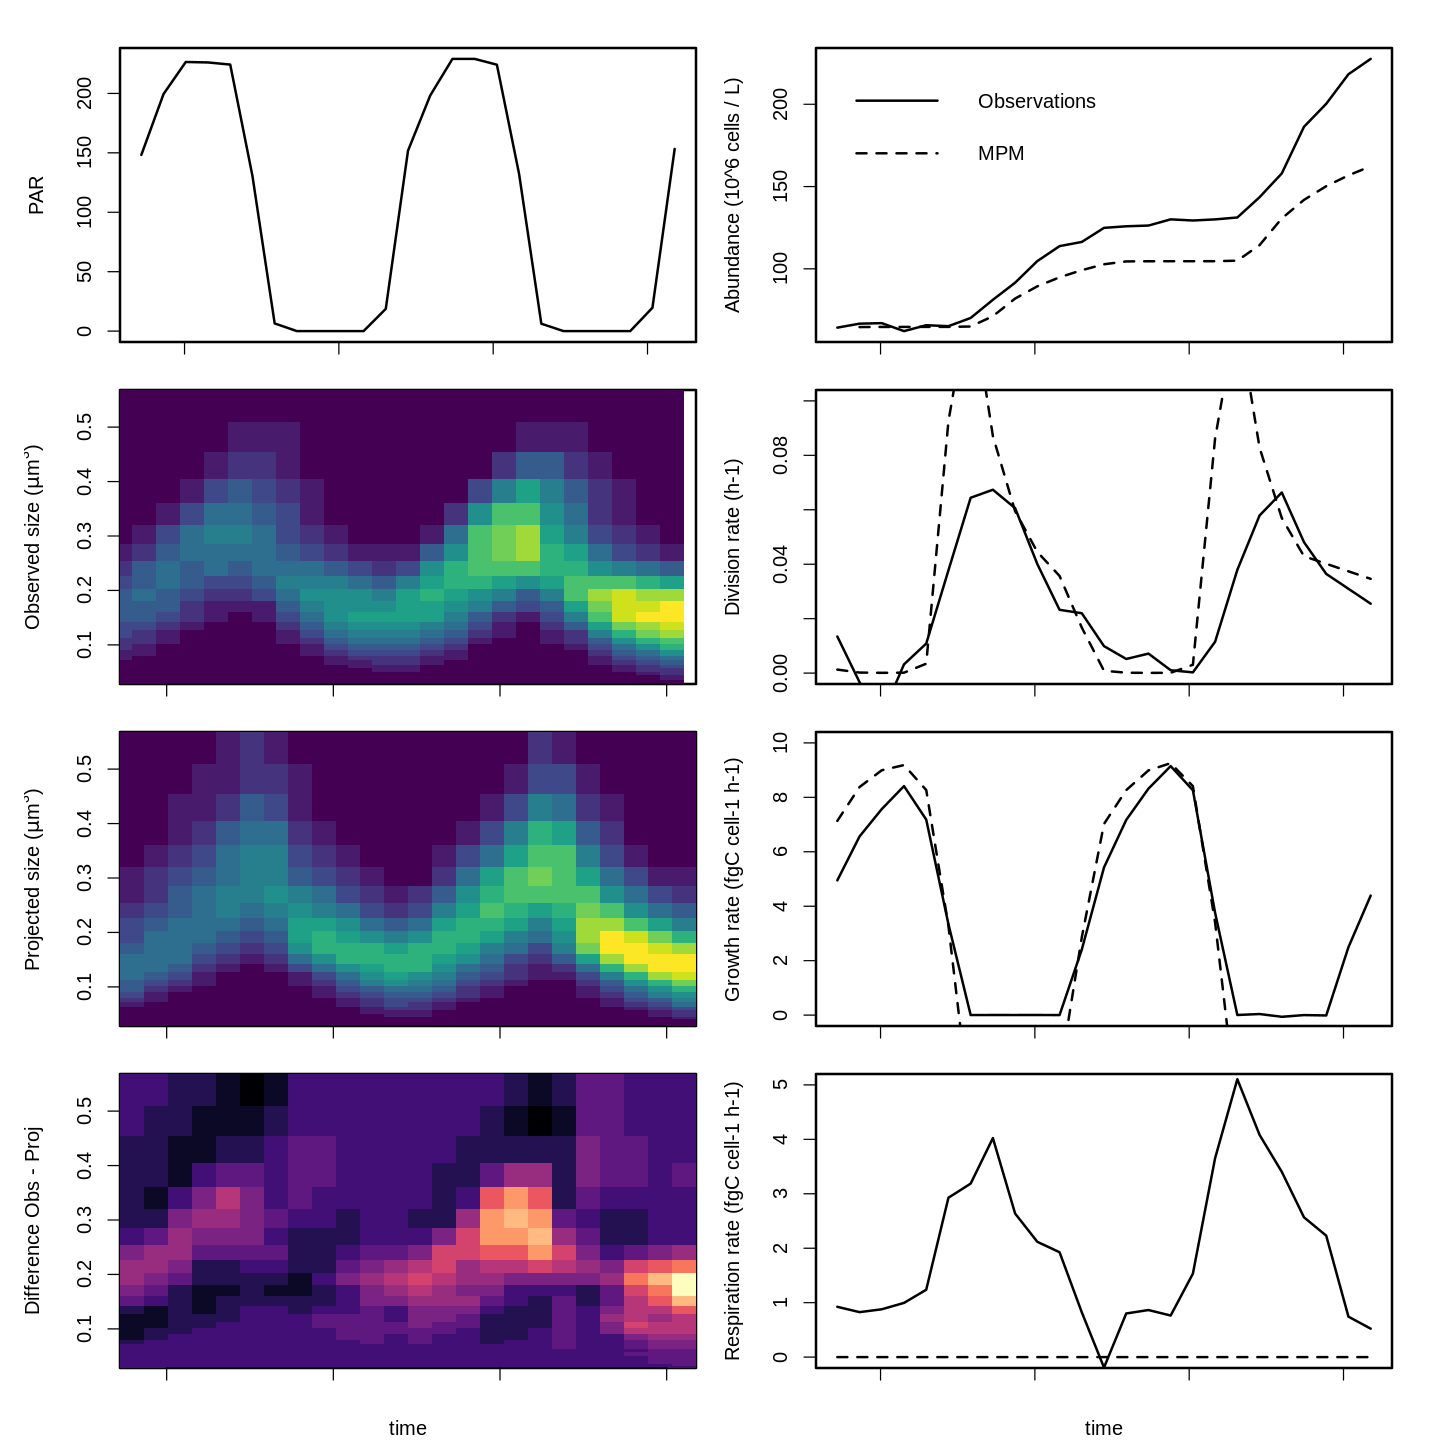

In [31]:
## Comparison Obs vs Model
#    'm1': '../stancode/matrixmodel_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
#    'm2': '../stancode/matrixmodel_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
#    'm3': '../stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
#    'm4': '../stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',
#    'm5': '../stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
#    'm6': '../stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',

i <- 4 # Select model


#colorRampPalette(c("red3", "white","lightblue1"))(15)
options(repr.plot.width = 12, repr.plot.height = 12)
layout(matrix(c(1:8), 4, 2, byrow = FALSE))

par(mar=c(1,4,1,1), oma=c(2,1,1,1), lwd=2, cex=1)

plot(time,PAR,type='l',xaxt='n')
axis(1,labels=NA)
image(x=time[-25],y=v,w_obs2[-25,],col=viridis(15), ylab=expression('Observed size ('*mu*'m'^3*')'), xaxt="n", xlim=range(time))
axis(1,labels=NA)
image(x=distribution$time,y=v,t(Nproj[[i]]),col=viridis(15),ylab=expression('Projected size ('*mu*'m'^3*')'), xaxt="n")
axis(1,labels=NA)
image(x=distribution$time,y=v,w_obs2[-25,]-t(Nproj[[i]]),col=viridis(15, option="A"),ylab=expression('Difference Obs - Proj'), xaxt="n")
axis(1, labels=NA)
mtext("time", 1, 2)

plot(time, abundance/10^6, type='l', xaxt="n", ylab="Abundance (10^6 cells / L)", xlim=range(time))
lines(time[-1], rowSums(t(Nproj[[i]]))/10^6, lty=2)
legend("topleft", c("Observations","MPM"), lty=c(1,2), bty="n")
axis(1,labels=NA)

plot(x=time[-24],y=dr, type='l', ylim=c(0, 0.1), xaxt='n',xlim=range(time), ylab="Division rate (h-1)")
lines(x=distribution$time[-c(23,24)],y=mu_N[[i]], lty=2)
axis(1,labels=NA)
plot(time, df2[,3], type='l', xaxt="n", ylim=c(0,10), xlim=range(time),ylab="Growth rate (fgC cell-1 h-1)")
lines(x=distribution$time[-c(23,24)],y=gr[[i]], lty=2)
axis(1,labels=NA)
plot(time, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', ylim=c(0,5), xlim=range(time), ylab="Respiration rate (fgC cell-1 h-1)")
lines(x=distribution$time[-c(23,24)], y = gr[[i]] *0, lty=2)
axis(1, labels=NA)
mtext("time", 1, 2)

In [17]:
# ## Comparison Obs vs Model
# options(repr.plot.width = 12, repr.plot.height = 18)
# layout(matrix(c(1:7), 7, 1, byrow = FALSE),
#        heights=c(0.3,1,1,1,1,1,1))

# par(mar=c(1,4,1,1), oma=c(3,1,1,1), lwd=2, cex=0.7)

# plot(time,PAR,type='l',xaxt='n')
# axis(1,labels=NA)
# image(x=time[-25],y=v,w_obs[-25,],col=viridis(15), ylab=expression('Observed size ('*mu*'m'^3*')'), xaxt="n", xlim=range(time))
# axis(1,labels=NA)
# image(x=distribution$time,y=v,Vproj,col=viridis(15, option="B"),ylab=expression('Projected size ('*mu*'m'^3*')'), xaxt="n")
# axis(1,labels=NA)
# plot(time, abundance/10^6, type='l', xaxt="n", ylab="Abundance (10^6 cells / L)", xlim=range(time))
# lines(distribution$time, rowSums(Nproj)/10^6, lty=2)
# legend("topleft", c("Observations","MPM"), lty=c(1,2), bty="n")
# axis(1,labels=NA)
# plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab="Division rate (h-1)")
# lines(x=distribution$time[-c(1)],y=mu_N, lty=2)
# axis(1,labels=NA)
# plot(time, df2[,3], type='l', xaxt="n", ylim=c(0,10), xlim=range(time),ylab="Growth rate (fgC cell-1 h-1)")
# lines(x=distribution$time[-49],y=gr, lty=2)
# axis(1,labels=NA)
# plot(time, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', ylim=c(0,5), xlim=range(time), ylab="Respiration rate (fgC cell-1 h-1)")
# lines(x=distribution$time[-49], y = gr *0, lty=2)
# axis(1, labels=NA)
# mtext("time", 1, 3)